In [49]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import  preprocessing
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

from qiskit import Aer, QuantumCircuit
from qiskit.algorithms.optimizers import SPSA, COBYLA, GradientDescent
from qiskit.circuit.library import TwoLocal, ZZFeatureMap, ZFeatureMap, PauliFeatureMap
from qiskit.circuit import Parameter
from qiskit.opflow import StateFn, Gradient, I, Z
from qiskit.utils import QuantumInstance

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import CircuitQNN, OpflowQNN
from qiskit_machine_learning.utils.loss_functions import L2Loss, CrossEntropyLoss

In [50]:
df = pd.read_csv('Datasets/Mentor/mock_train_set.csv')
df.head(8)

,0,1,2,3,x
0,2789.26,1000,10,20,0
1,4040.01,1000000,1,1,1
2,2931.20,10000,10000,40,1
3,3896.54,10000,100000,30,1
4,982.06,100,1000,75,0
5,1579.81,1,1000,90,0
6,3031.77,1000000,1000000,35,1
7,860.44,10,100000,60,0


In [51]:
df_test = pd.read_csv('Datasets/Mentor/mock_test_set.csv')
df_test.head(8)

,0,1,2,3,x
0,2988.55,10000,10000,75,1
1,3413.80,1,100,90,0
2,3891.52,1,1,5,0
3,4514.99,10000,1000000,25,1
4,752.29,10,10,90,0
5,1404.13,10000,1000,5,1
6,3390.65,1000000,10000,5,1
7,2620.98,1,10,75,0


In [52]:
f_name_list = list(df)
list(f_name_list)

['0', '1', '2', '3', 'x']

In [53]:
print('Number of empty data in the set: '), df.isnull().sum().sum()
clean_data = df.dropna()

Number of empty data in the set: 


In [54]:
#clean_data = clean_data.drop('Unnamed: 0', axis=1)
x_org = clean_data.drop('x', axis=1)
cat = clean_data.x

rel = ExtraTreesClassifier()
rel.fit(x_org, cat)

ExtraTreesClassifier()

In [55]:
print(rel.feature_importances_)

[0.13735009 0.48872389 0.27231861 0.1016074 ]


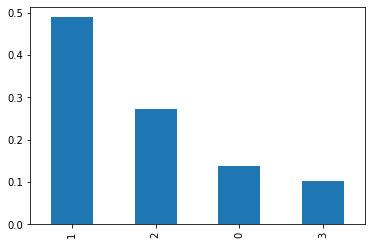

In [56]:
rank_f = pd.Series(rel.feature_importances_, index=x_org.columns)
rank_f.nlargest(20).plot(kind='bar')
plt.show()

In [57]:
corr = clean_data.iloc[:,:-1].corr()
classified = mutual_info_classif(x_org, cat)
class_data = pd.Series(classified, index=x_org.columns)
ordered_f = class_data.sort_values(ascending=False)

In [58]:
ordered_f.head(10)

1    0.309729
2    0.258882
0    0.060894
3    0.047230
dtype: float64

In [59]:
test_ratio = 0.2
seed = 1984
selected_f = clean_data[['0','1','2','3','x']]
selected_test = df_test[['0','1','2','3','x']]

x_train = np.array(selected_f.drop('x', axis =1))
y_train = np.array(selected_f.x)
x = preprocessing.normalize(x_train, axis=0)

x_test = np.array(selected_test.drop('x', axis =1))
y_test = np.array(selected_test.x)
x = preprocessing.normalize(x_test, axis=0)

#x_train, x_test, y_train, y_test = train_test_split(x, cat, test_size=test_ratio, random_state=seed, stratify=cat)

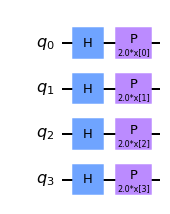

In [60]:
feature_dim = x.shape[1]
emb_layer = 1
ent = 'linear'

fmap = ZFeatureMap(feature_dimension=feature_dim, reps=emb_layer)#, entanglement=ent)
fmap.decompose().draw('mpl', scale=1)

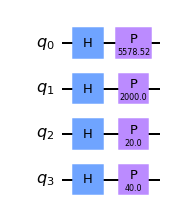

In [61]:
fmap.assign_parameters({k:v for (k,v) in zip(fmap.parameters, x_train[0])}).decompose().draw('mpl', scale=1)

In [62]:
def ansatz_circ(feature_dim, layer, weights):
    ansatz = QuantumCircuit(feature_dim)
    for layer in range(layer):
        for i in range(feature_dim):
            ansatz.ry(weights[i], i)
            ansatz.rz(weights[i+4], i)
        for i in range(feature_dim - 1):
            ansatz.cx(i, i+1)
            ansatz.barrier()
            ansatz.rz(weights[i+8], i+1)
        ansatz.barrier()
    return ansatz

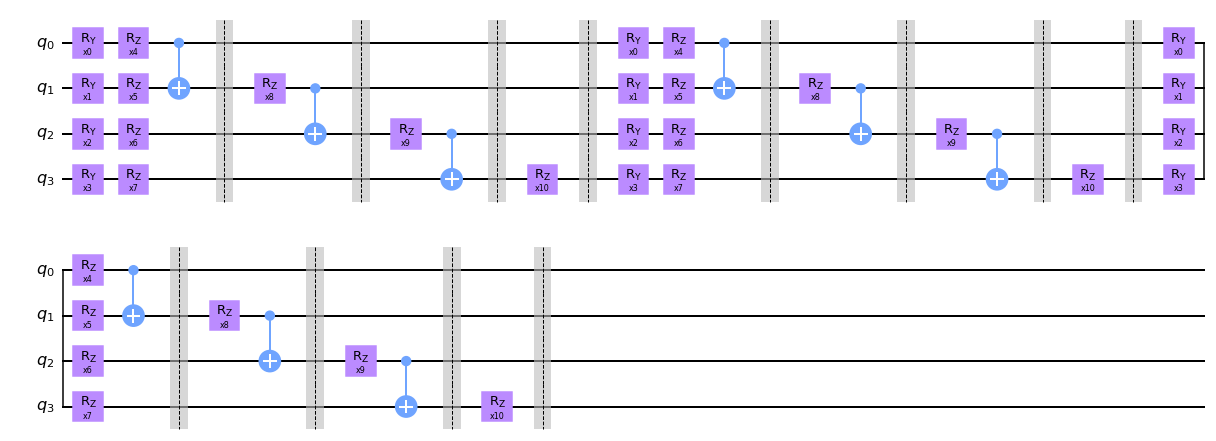

In [63]:
layer = 3
np.random.seed(seed)
nb_w = 11
weights = np.random.random(nb_w)
w_params = [Parameter(f'x{str(i)}') for i in range(nb_w)]

ansatz = ansatz_circ(feature_dim, layer, w_params)
ansatz.draw('mpl')

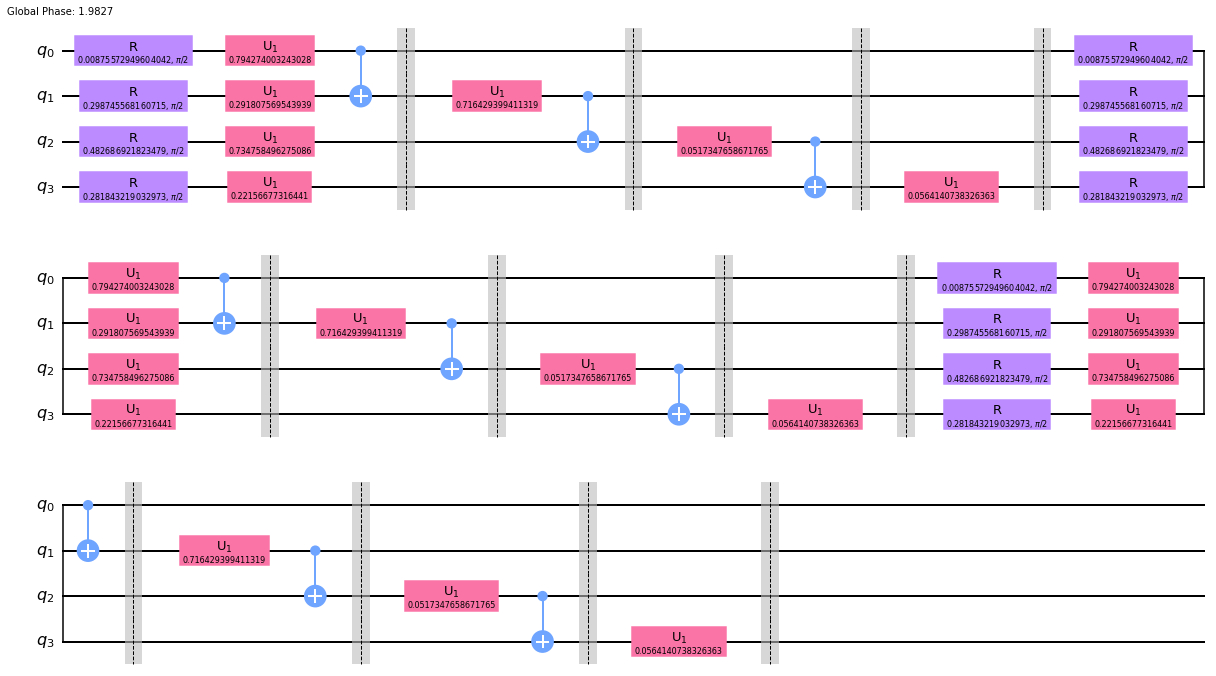

In [64]:
ansatz.assign_parameters({k:v for (k,v) in zip(ansatz.parameters, weights)}).decompose().draw('mpl', scale=1)

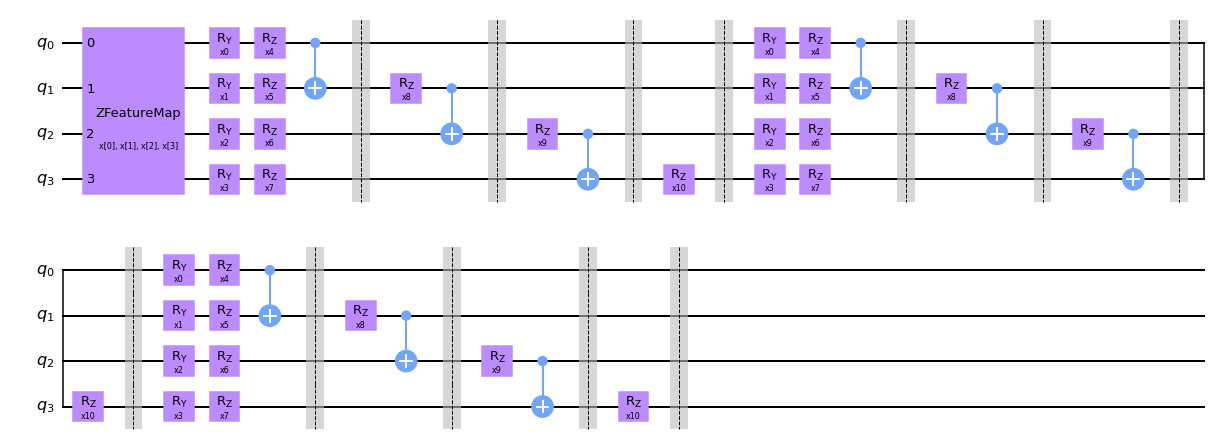

In [65]:
var_circuit = fmap.compose(ansatz)
var_circuit.draw('mpl')

In [66]:
def parity(x, num_classes):
    return f"{x:b}".count("1") % num_classes

def one_qubit_binary(x):
    return x % 2

In [67]:
qasm_sim = Aer.get_backend('aer_simulator')
qinst = QuantumInstance(qasm_sim, 2048, seed_simulator=seed)

In [68]:
num_classes = 2
qnn = CircuitQNN(circuit=var_circuit,
                 input_params=fmap.parameters,  # if your embedding strategy is not a parametrized circuit 
                                                   # (e.g. amplitude encoding) you will have to do some extra work!
                 weight_params=ansatz.parameters,  # if you train your embedding as well, the trainable
                                                      # parameters of the embedding must be added
                 interpret=one_qubit_binary,
                 output_shape=num_classes,
                 gradient=None,
                 quantum_instance=qinst)

In [69]:
output = qnn.forward(x_train[0], weights)
print(output.shape)
output

(1, 2)


array([[0.51171875, 0.48828125]])

In [70]:
_, update = qnn.backward(x_train[0], weights)
update

array([[[ 0.14770508,  0.01708984,  0.00415039, -0.00537109,
          0.01367188, -0.00048828,  0.00073242, -0.01074219,
          0.00341797,  0.01342773,  0.01782227],
        [-0.14770508, -0.01708984, -0.00415039,  0.00537109,
         -0.01367188,  0.00048828, -0.00073242,  0.01074219,
         -0.00341797, -0.01342773, -0.01782227]]])

In [71]:
def get_one_hot_encoding(y):
    unique_labels = np.unique(y, axis=0)
    y_one_hot = [(np.eye(len(unique_labels))[np.where(unique_labels == y_i)]).reshape(len(unique_labels)) for y_i in y]

    return np.array(y_one_hot)

y_train_1h = get_one_hot_encoding(y_train)
y_test_1h = get_one_hot_encoding(y_test)

In [72]:
def callback(nfev, params, fval, stepsize, accepted=None):
    """
    Can be used for SPSA and GradientDescent optimizers
    nfev: the number of function evals
    params: the current parameters
    fval: the current function value
    stepsize: size of the update step
    accepted: whether the step was accepted (not used for )
    """
    global loss_recorder

    loss_recorder.append(fval)
    print(f'{nfev} - {fval}')

In [73]:
max_itr = 50
spsa_opt = SPSA(maxiter=max_itr, callback=callback)
loss_recorder = []
np.random.seed(seed)
initial_point = np.random.random((len(ansatz.parameters),))
vqc = NeuralNetworkClassifier(neural_network=qnn,
                              loss=CrossEntropyLoss(),
                              one_hot=True,
                              optimizer=spsa_opt,
                              initial_point=initial_point)


vqc = vqc.fit(x_train, y_train_1h)

In [ ]:
score_train_1 = vqc.score(x_train, y_train_1h)
score_test_1 = vqc.score(x_test, y_test_1h)
print(f'Score on the train set {score_train_1}')
print(f'Score on the test set {score_test_1}')

Score on the train set 0.54
Score on the test set 0.5833333333333334


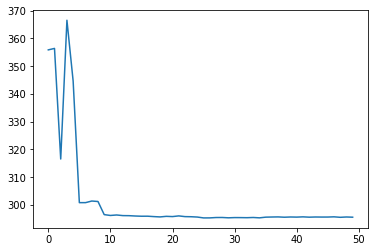

In [ ]:
plt.plot(loss_recorder)

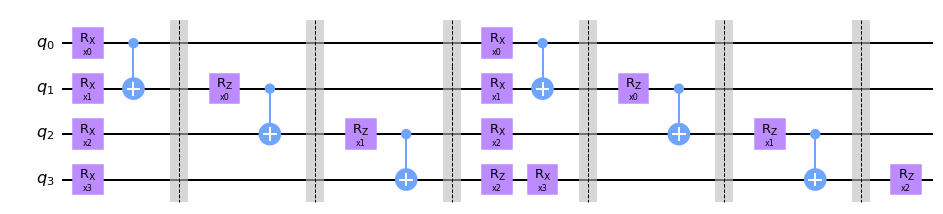

In [ ]:
layer = 2
np.random.seed(seed)
weights = np.random.random(nb_w)
w_params = [Parameter(f'x{str(i)}') for i in range(nb_w)]

ansatz = ansatz_circ(feature_dim, layer, w_params)
ansatz.draw('mpl')

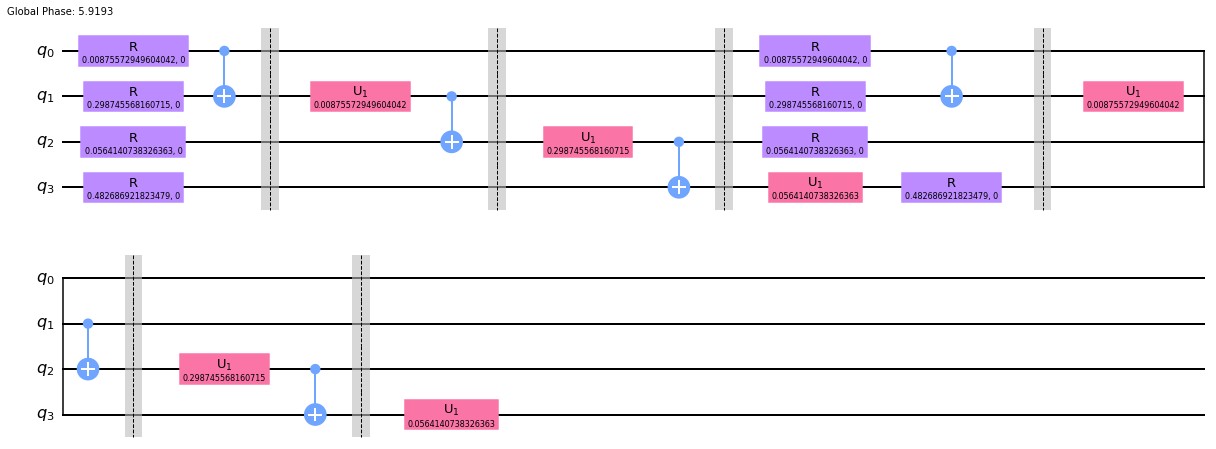

In [ ]:
ansatz.assign_parameters({k:v for (k,v) in zip(ansatz.parameters, weights)}).decompose().draw('mpl', scale=1)

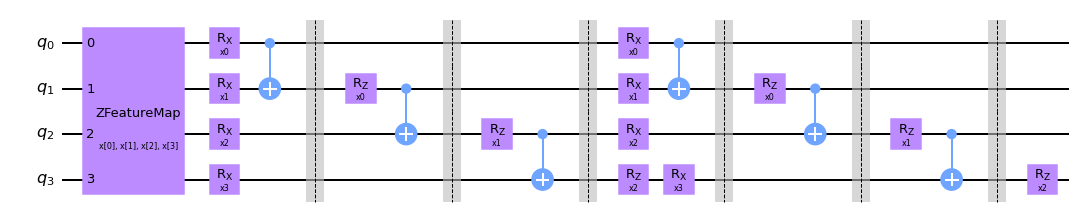

In [ ]:
var_circuit = fmap.compose(ansatz)
var_circuit.draw('mpl')

In [ ]:
qnn = CircuitQNN(circuit=var_circuit,
                 input_params=fmap.parameters,  # if your embedding strategy is not a parametrized circuit 
                                                   # (e.g. amplitude encoding) you will have to do some extra work!
                 weight_params=ansatz.parameters,  # if you train your embedding as well, the trainable
                                                      # parameters of the embedding must be added
                 interpret=one_qubit_binary,
                 output_shape=num_classes,
                 gradient=None,
                 quantum_instance=qinst)

In [ ]:
output = qnn.forward(x_train[0], weights)
print(output.shape)
output

(1, 2)


array([[0.49804688, 0.50195312]])

In [ ]:
_, update = qnn.backward(x_train[0], weights)
update

array([[[-0.24902344,  0.02368164,  0.01513672, -0.01879883],
        [ 0.24902344, -0.02368164, -0.01513672,  0.01879883]]])

In [ ]:
max_itr = 50
spsa_opt = SPSA(maxiter=max_itr, callback=callback)
loss_recorder = []
np.random.seed(seed)
initial_point = np.random.random((len(ansatz.parameters),))
vqc = NeuralNetworkClassifier(neural_network=qnn,
                              loss=CrossEntropyLoss(),
                              one_hot=True,
                              optimizer=spsa_opt,
                              initial_point=initial_point)


vqc = vqc.fit(x_train, y_train_1h)

KeyboardInterrupt: 

In [ ]:
score_train_2 = vqc.score(x_train, y_train_1h)
score_test_2 = vqc.score(x_test, y_test_1h)
print(f'Score on the train set {score_train_2}')
print(f'Score on the test set {score_test_2}')

Score on the train set 0.7966666666666666
Score on the test set 0.8166666666666667


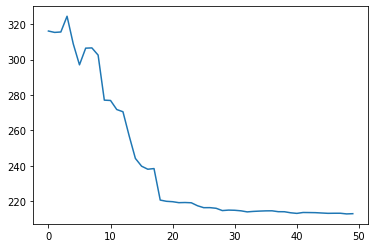

In [ ]:
plt.plot(loss_recorder)

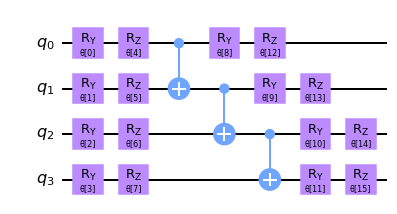

In [ ]:
layer = 1
np.random.seed(seed)
weights = np.random.random(nb_w)
w_params = [Parameter(f'x{str(i)}') for i in range(nb_w)]

ansatz = ansatz_circ(feature_dim, layer, w_params)
ansatz.draw('mpl')

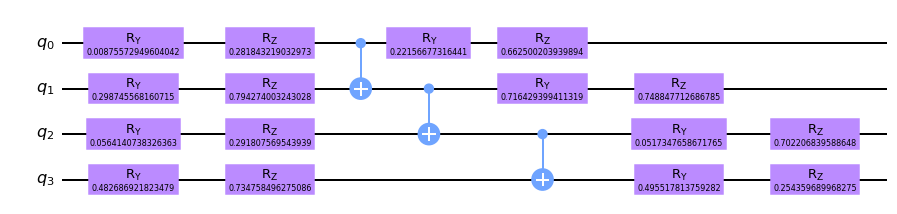

In [ ]:
ansatz.assign_parameters({k:v for (k,v) in zip(ansatz.parameters, weights)}).decompose().draw('mpl', scale=1)

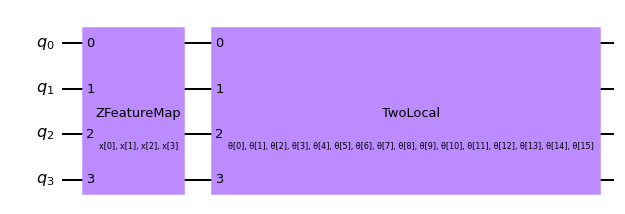

In [ ]:
var_circuit = fmap.compose(ansatz)
var_circuit.draw('mpl')

In [ ]:
qnn = CircuitQNN(circuit=var_circuit,
                 input_params=fmap.parameters,  # if your embedding strategy is not a parametrized circuit 
                                                   # (e.g. amplitude encoding) you will have to do some extra work!
                 weight_params=ansatz.parameters,  # if you train your embedding as well, the trainable
                                                      # parameters of the embedding must be added
                 interpret=one_qubit_binary,
                 output_shape=num_classes,
                 gradient=None,
                 quantum_instance=qinst)

In [ ]:
output = qnn.forward(x_train[0], weights)
print(output.shape)
output

(1, 2)


array([[0.56738281, 0.43261719]])

In [ ]:
_, update = qnn.backward(x_train[0], weights)
update

array([[[-0.29003906, -0.00195313,  0.00317383,  0.00268555,
          0.06616211,  0.03344727,  0.00097656, -0.00048828,
          0.34301758,  0.00878906,  0.00952148,  0.00146484,
         -0.01293945,  0.00390625, -0.00219727, -0.01391602],
        [ 0.29003906,  0.00195313, -0.00317383, -0.00268555,
         -0.06616211, -0.03344727, -0.00097656,  0.00048828,
         -0.34301758, -0.00878906, -0.00952148, -0.00146484,
          0.01293945, -0.00390625,  0.00219727,  0.01391602]]])

In [ ]:
max_itr = 50
spsa_opt = SPSA(maxiter=max_itr, callback=callback)
loss_recorder = []
np.random.seed(seed)
initial_point = np.random.random((len(ansatz.parameters),))
vqc = NeuralNetworkClassifier(neural_network=qnn,
                              loss=CrossEntropyLoss(),
                              one_hot=True,
                              optimizer=spsa_opt,
                              initial_point=initial_point)


vqc = vqc.fit(x_train, y_train_1h)

3 - 358.8970431052113
6 - 318.1759045803168
9 - 359.94128405066556
12 - 319.05643968775064
15 - 354.0040013857393
18 - 463.6171730077227
21 - 372.10329822219177
24 - 373.11856564180994
27 - 344.35833348066126
30 - 314.9694114637616
33 - 319.8910498926259
36 - 356.38832849307755
39 - 328.10758733739203
42 - 326.7164638403822
45 - 311.14243784554213
48 - 308.4799430188459
51 - 301.3054026636689
54 - 300.56980952893144
57 - 300.5460993448457
60 - 298.78978068708636
63 - 298.3744197317138
66 - 296.62672038701044
69 - 296.55613836913085
72 - 296.8858694601361
75 - 296.8892463228473
78 - 296.5729002106636
81 - 296.37251050621325
84 - 296.39306944599423
87 - 296.40674970169056
90 - 296.4095632491594
93 - 296.5383278373379
96 - 296.1953837132386
99 - 296.21436534932036
102 - 296.08592417815555
105 - 296.07175100682645
108 - 296.17341369511706
111 - 296.0287818276271
114 - 296.20340429727
117 - 296.24295100670906
120 - 296.23382449316387
123 - 296.17627746749974
126 - 296.12100331513216
129 - 2

In [ ]:
score_train_3 = vqc.score(x_train, y_train_1h)
score_test_3 = vqc.score(x_test, y_test_1h)
print(f'Score on the train set {score_train_3}')
print(f'Score on the test set {score_test_3}')

Score on the train set 0.5433333333333333
Score on the test set 0.5166666666666667


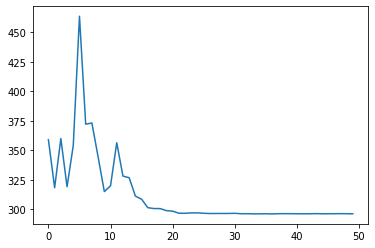

In [ ]:
plt.plot(loss_recorder)